In [1]:
import pandas as pd
from tqdm.notebook import tqdm

dftrain = pd.read_csv('Rnn_train.csv')
dftest = pd.read_csv('Rnn_test.csv')
dftest = dftest[~pd.isna(dftest.POS)]

sen = ''
for i in tqdm(range(dftrain.shape[0])) :
  s = dftrain.iloc[i,0]
  if type(s) == type('') :
    sen = s
  else :
    dftrain.iloc[i,0] = sen

for i in tqdm(range(dftest.shape[0])) :
  s = dftest.iloc[i,0]
  if type(s) == type('') :
    sen = s
  else :
    dftest.iloc[i,0] = sen

train_sentences = list()
test_sentences = list()
train_tags = list()
test_tags = list()

for sen,data in tqdm(dftrain.groupby(dftrain.columns[0])) :
  train_sentences.append(data.Word.values.tolist())
  train_tags.append(data.POS.values.tolist())

for sen,data in tqdm(dftest.groupby(dftest.columns[0])) :
  test_sentences.append(data.Word.values.tolist())
  test_tags.append(data.POS.values.tolist())

In [2]:
words, tags = set(), set()
 
for s in train_sentences:
    for w in s:
        words.add(w.lower())
 
tags = pd.read_csv('pos_list.csv').POS_list
 
word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0
word2index['-OOV-'] = 1
 
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0

index2tag = {i: t for t,i in tag2index.items()}

train_X = list(map(lambda sen: list(map(lambda word: word2index.get(word,word2index['-OOV-']), sen)), tqdm(train_sentences)))
test_X = list(map(lambda sen: list(map(lambda word: word2index.get(word,word2index['-OOV-']), sen)), tqdm(test_sentences)))
train_Y = list(map(lambda sen: list(map(lambda word: tag2index[word], sen)), tqdm(train_tags)))
test_Y = list(map(lambda sen: list(map(lambda word: tag2index[word], sen)), tqdm(test_tags)))

MAX_LENGTH = max(list(map(len, train_X+test_X)))
print(MAX_LENGTH)


104


In [3]:
from keras.preprocessing.sequence import pad_sequences
 
train_X = pad_sequences(train_X, maxlen=MAX_LENGTH, padding='post')
test_X = pad_sequences(test_X, maxlen=MAX_LENGTH, padding='post')
train_Y = pad_sequences(train_Y, maxlen=MAX_LENGTH, padding='post')
test_Y = pad_sequences(test_Y, maxlen=MAX_LENGTH, padding='post')

Using TensorFlow backend.


In [4]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
 
 
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 128)          2704768   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 512)          788480    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 43)           22059     
_________________________________________________________________
activation_1 (Activation)    (None, 104, 43)           0         
Total params: 3,515,307
Trainable params: 3,515,307
Non-trainable params: 0
_________________________________________________________________


In [0]:
import numpy as np

def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [6]:
model.fit(train_X, to_categorical(train_Y, len(tag2index)), batch_size=128, epochs=10, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 147s 9ms/step - loss: 0.7747 - accuracy: 0.8196 - val_loss: 0.5339 - val_accuracy: 0.8619
Epoch 2/10
16000/16000 [==============================] - 146s 9ms/step - loss: 0.4034 - accuracy: 0.8988 - val_loss: 0.2409 - val_accuracy: 0.9369
Epoch 3/10
16000/16000 [==============================] - 144s 9ms/step - loss: 0.1487 - accuracy: 0.9626 - val_loss: 0.0897 - val_accuracy: 0.9780
Epoch 4/10
16000/16000 [==============================] - 151s 9ms/step - loss: 0.0641 - accuracy: 0.9841 - val_loss: 0.0570 - val_accuracy: 0.9850
Epoch 5/10
16000/16000 [==============================] - 146s 9ms/step - loss: 0.0439 - accuracy: 0.9882 - val_loss: 0.0491 - val_accuracy: 0.9859
Epoch 6/10
16000/16000 [==============================] - 147s 9ms/step - loss: 0.0361 - accuracy: 0.9899 - val_loss: 0.0430 - val_accuracy: 0.9875
Epoch 7/10
16000/16000 [==============================] - 145s 

In [0]:
def flatten(lol) :
  l = list()
  for nl in lol :
    l += nl
  return l

indexes2tags = lambda l: list(map(lambda i: index2tag[i], l))

predicted = model.predict(test_X)
predicted = list(map(lambda p: p.argmax(axis=1), predicted))
predicted = list(map(lambda p,l: p[:l], predicted, list(map(len, test_sentences))))
predicted = list(map(indexes2tags, predicted))
dftest.Predict = flatten(predicted)

In [14]:
acc = (dftest.POS == dftest.Predict).sum() / dftest.shape[0]
print('Accuracy =', acc)

Accuracy = 0.9396501806082777


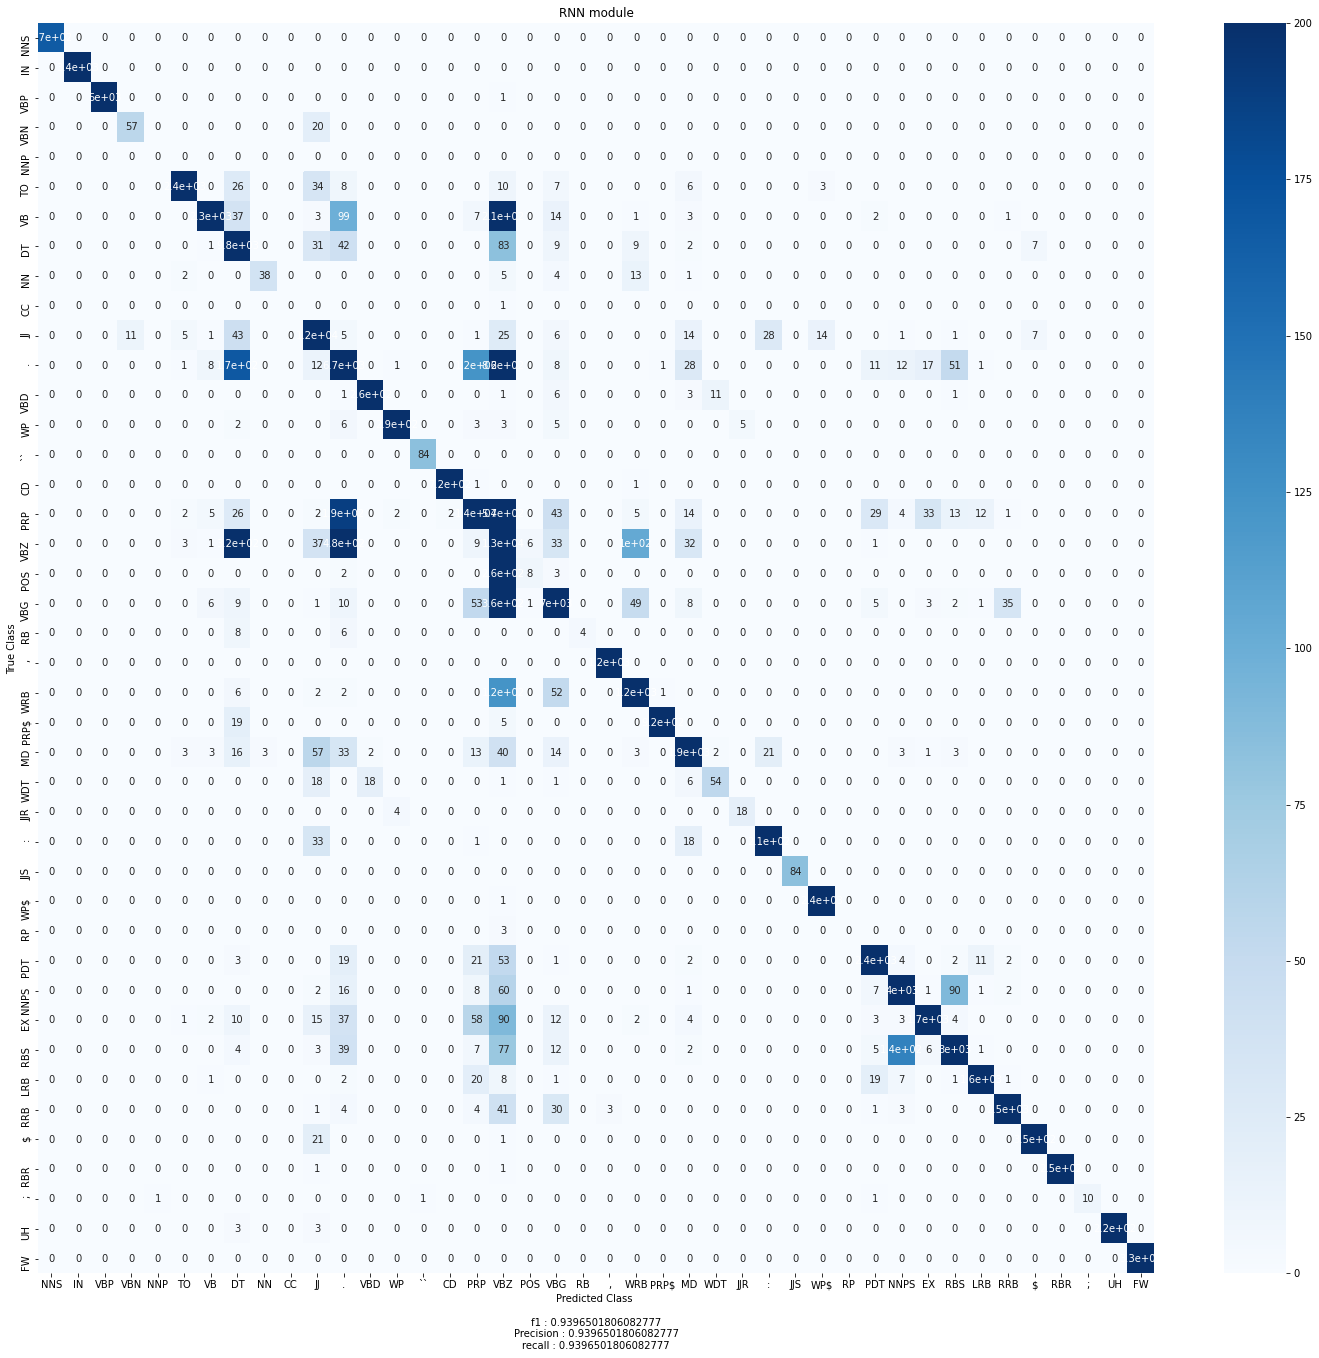

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sn

fig, ax = plt.subplots(figsize=(25,23))
l,p = dftest.POS.tolist(), dftest.Predict.tolist()
cm = confusion_matrix(l,p)
df_cm = pd.DataFrame(cm, tags, tags)
sn.heatmap(df_cm, annot=True, cmap="Blues", ax=ax, vmax=200)
ax.set_title('RNN module')
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class \n\n'
    'f1 : ' + str(f1_score(l,p, average='micro')) + '\n' + \
    'Precision : ' + str(precision_score(l,p, average='micro')) + '\n' + \
    'recall : ' + str(recall_score(l,p, average='micro'))
)
plt.show()

In [15]:
print('f1 : ' + str(f1_score(l,p, average='micro')) + '\n' + \
    'Precision : ' + str(precision_score(l,p, average='micro')) + '\n' + \
    'recall : ' + str(recall_score(l,p, average='micro')))

f1 : 0.9396501806082777
Precision : 0.9396501806082777
recall : 0.9396501806082777


In [0]:
dftest.to_csv('RNN_result.csv')